In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

In [3]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]

In [4]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   race_year_id          112176 non-null  int64   
 1   ranking               112176 non-null  float64 
 2   runner                112176 non-null  object  
 3   time                  112176 non-null  object  
 4   age                   112176 non-null  float64 
 5   gender                112176 non-null  object  
 6   nationality           112176 non-null  object  
 7   time_in_seconds       112176 non-null  float64 
 8   runner_id             112176 non-null  object  
 9   age_course            112176 non-null  float64 
 10  age_range             112176 non-null  category
 11  speed                 112176 non-null  float64 
 12  equivalent_speed      112176 non-null  float64 
 13  event                 112176 non-null  object  
 14  race                  112176 non-nul

<AxesSubplot:xlabel='year', ylabel='count'>

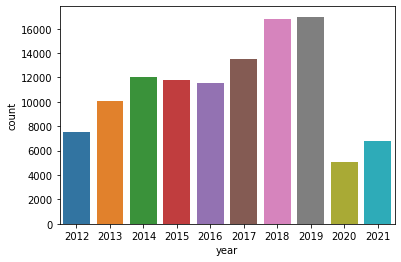

In [5]:
sns.countplot(
    x = 'year',
    data = join
)

## Prédiction de performance pour les coureurs en 2019

In [6]:
sample_df = join.sample(10000)

In [35]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    year_to_predict = race_to_predict.iloc[0]['year']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.year == year_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.year < year_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        has_run = 0
        total_distance = 0
        total_races = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        
            
        if runner_past.size > 0: 
            has_run = 1
            total_distance =  runner_past.equivalent_distance.sum()
            total_races = runner_past.shape[0]
            ranking_score = 
               
            if len(runner_past.loc[runner_past.year == (year_to_predict - 1)]) > 0:
                has_run_last_year = 1
                distance_previous_year = runner_past.loc[runner_past.year == (year_to_predict - 1)].equivalent_distance.sum()
            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'total_distance': total_distance,
                        'distance_previous_year': distance_previous_year,
                        'total_races': total_races,
                        'has_run': has_run,
                        'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year
                       }, ignore_index = True)
    return df

In [36]:
runner_p = runner_profile(join,race, 54013)

100%|█████████████████████████████████████████| 692/692 [00:07<00:00, 96.61it/s]


In [37]:
runner_p

,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year
0,TIPHENEGuillaumeFRAM27.0,27.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MAESPaulFRAM34.0,34.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NADRISamirFRAM25.0,25.0,M,FRA,269.9,269.9,1.0,1.0,1.0,1.0,0.0
3,HingrandCorentinFRAM24.0,24.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FRANCOISFlorentFRAM31.0,31.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
687,BERKIAEmmanuelleFRAW44.0,44.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688,LEBONSebastienFRAM45.0,45.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,TONDELLIERChouFRAW34.0,34.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,GALATEAUJulieFRAW33.0,33.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='distance_previous_year', ylabel='count'>

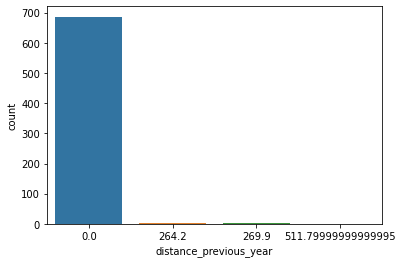

In [39]:
sns.countplot(
    x = runner_p.distance_previous_year
)

In [40]:
join

,race_year_id,ranking,runner,time,age,gender,nationality,time_in_seconds,runner_id,age_course,...,elevation_gain,elevation_loss,aid_stations,participants,year,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation
0,68140,1.0,VERHEUL Jasper,26H 35M 25S,30.0,M,GBR,95725.0,VERHEULJasperGBRM30.0,30.0,...,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
1,68140,2.0,MOULDING JON,27H 0M 29S,43.0,M,GBR,97229.0,MOULDINGJONGBRM43.0,43.0,...,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
2,68140,3.0,RICHARDSON Phill,28H 49M 7S,38.0,M,GBR,103747.0,RICHARDSONPhillGBRM38.0,38.0,...,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
3,68140,4.0,DYSON Fiona,30H 53M 37S,55.0,W,GBR,111217.0,DYSONFionaGBRW55.0,55.0,...,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
4,68140,5.0,FRONTERAS Karen,32H 46M 21S,48.0,W,GBR,117981.0,FRONTERASKarenGBRW48.0,48.0,...,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112181,3253,42.0,MARR Gary,35H 29M 0S,70.0,M,USA,127740.0,MARRGaryUSAM70.0,61.0,...,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248
112182,3253,43.0,SCHOLZ Monica,35H 37M 0S,54.0,W,CAN,128220.0,SCHOLZMonicaCANW54.0,45.0,...,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248
112183,3253,44.0,GRYFE Robert,35H 46M 0S,55.0,M,CAN,128760.0,GRYFERobertCANM55.0,46.0,...,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248
112184,3253,45.0,ESCOBAR Luis James,35H 48M 0S,58.0,M,USA,128880.0,ESCOBARLuisJamesUSAM58.0,49.0,...,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248
